# Picking an integrator/dynamical model

`jorbit` includes a few different numerical integrators and gravity models of varying complexity and speed. When creating `Particle` objects, the default is to use the implementation of IAS15 for the integrator and a gravity model that accounts for the Sun and major planets using parameterized post-Newtonian corrections as well as Newtonian influences from several massive asteroids. As shown in the release paper, this combination replicates the predictions of JPL Horizons to ~mas agreement over ~decade timescales: however, we don't always need this level of precision, especially across short initial observation arcs. Here we'll demonstrate how to explore different choices of integrators and gravity models to pick the best one for your use case.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import System, Particle, Observations

In [2]:
times = Time("2026-01-01") + jnp.arange(0, 365 * 5, 10) * u.day

reference_particle = Particle.from_horizons(
    name="274301",
    time=Time("2026-01-01"),
    integrator="ias15",
    gravity="default solar system",
)
reference_ephem = reference_particle.ephemeris(times, observer="kitt peak")

In [3]:
errors = []
for integrator in ["Y4", "Y6", "Y8"]:
    print(f"Integrator: {integrator}")
    gravity_errors = []
    for gravity in ["newtonian planets", "default solar system"]:
        step_errors = []
        for max_step in [1 * u.day, 5 * u.day]:
            p = Particle.from_horizons(
                name="274301",
                time=Time("2026-01-01"),
                integrator=integrator,
                gravity=gravity,
                max_step_size=max_step,
            )
            eph = p.ephemeris(times, observer="kitt peak")
            errs = reference_ephem.separation(eph).to(u.arcsec).value
            step_errors.append(errs)
        gravity_errors.append(step_errors)
    errors.append(gravity_errors)

Integrator: Y4
Integrator: Y6
Integrator: Y8


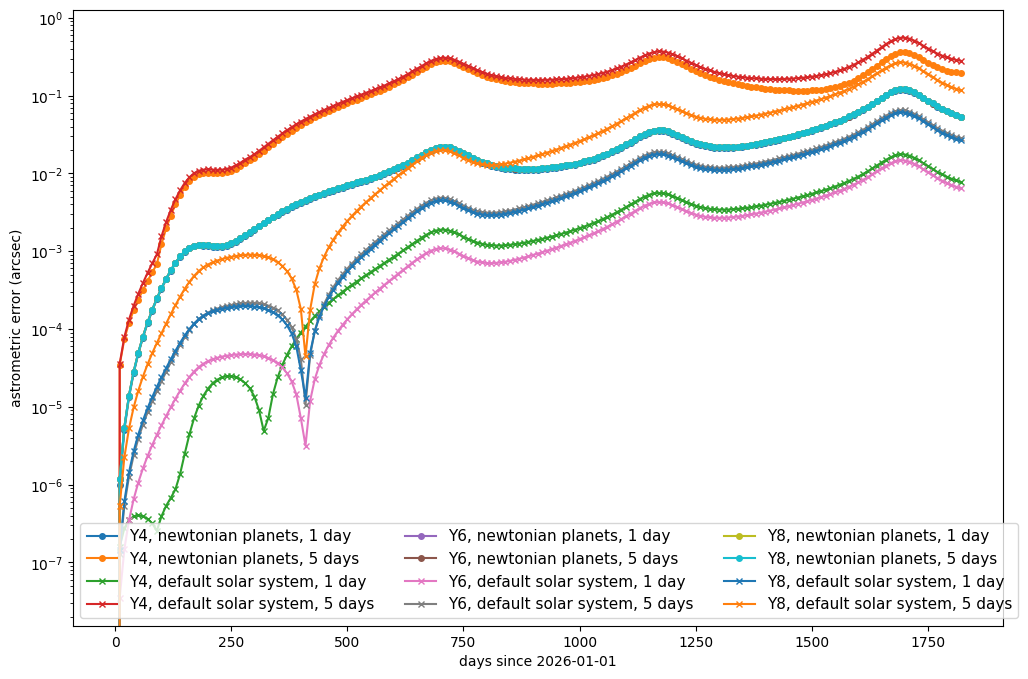

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, integrator in enumerate(["Y4", "Y6", "Y8"]):
    # note that the other gravity choices include "gr planets", "gr solar system",
    # "generic newtonian" (no other masses), and "generic gr" (no other masses)
    for j, gravity in enumerate(["newtonian planets", "default solar system"]):
        label = f"{integrator}, {gravity}"
        ax.plot(
            times.jd - times.jd[0],
            errors[i][j][0],
            marker="o" if j == 0 else "x",
            markersize=4,
            label=label + ", 1 day",
        )
        ax.plot(
            times.jd - times.jd[0],
            errors[i][j][1],
            marker="o" if j == 0 else "x",
            markersize=4,
            label=label + ", 5 days",
        )
ax.set_yscale("log")
ax.set_ylabel("astrometric error (arcsec)")
ax.set_xlabel("days since 2026-01-01")
ax.legend(ncols=3, fontsize=11)

Each of these simpler methods reach >mas errors in less than 5 years, but how fast that error grows clearly depends on the choice of the integrator and gravity model.

Outside of the context of solar system orbits, we can get a sense for how changing the step size changes the accuracy of the integrator by simulating a simple circular orbit. Note that the slope of the decrease in error with increasing steps per orbit indicates the order of the integrator.

In [5]:
from jorbit.utils.states import SystemState

s0 = SystemState(
    massive_positions=jnp.array([[0.0, 0.0, 0.0]]),
    massive_velocities=jnp.array([[0.0, 0.0, 0.0]]),
    tracer_positions=jnp.array([[1.0, 0.0, 0.0]]),
    tracer_velocities=jnp.array([[0.0, 1.0, 0.0]]),
    log_gms=jnp.array([0.0]),
    time=0.0,
    acceleration_func_kwargs={},
    fixed_perturber_positions=jnp.empty((0, 3)),
    fixed_perturber_velocities=jnp.empty((0, 3)),
    fixed_perturber_log_gms=jnp.empty((0,)),
)

steps_per_orbit = jnp.ceil(jnp.logspace(1, 3, 20))

errors = []
for integrator in ["Y4", "Y6", "Y8"]:
    integrator_errors = []
    for s in steps_per_orbit:
        s = System(
            state=s0,
            gravity="generic newtonian",
            integrator=integrator,
            max_step_size=2 * jnp.pi / s * u.day,
        )
        x, v = s.integrate(jnp.array([2 * jnp.pi]))
        error = jnp.sqrt(jnp.sum((x[0, 1] - jnp.array([[1.0, 0.0, 0.0]])) ** 2))
        integrator_errors.append(error)
    errors.append(integrator_errors)

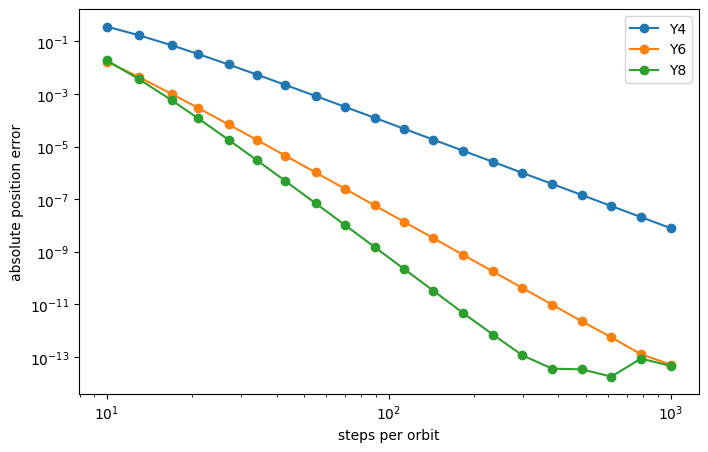

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
for i, integrator in enumerate(["Y4", "Y6", "Y8"]):
    ax.plot(steps_per_orbit, errors[i], marker="o", label=integrator)
ax.set(
    xscale="log",
    yscale="log",
    xlabel="steps per orbit",
    ylabel="absolute position error",
)
ax.legend()